In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import math
from xgboost import XGBRegressor

In [2]:
# Previous lines are to test the Word2Vec model
# Code starts here
# Reading Hansen and SMILES data from gpHSP
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')

mol_smiles = gpHSP_data['SMILES']
hansen_d = gpHSP_data['hansen_d']
hansen_p = gpHSP_data['hansen_p']
hansen_h = gpHSP_data['hansen_h']
mol_number = gpHSP_data['number']
mol_name = gpHSP_data['Molecule']

hansen_total = np.sqrt((hansen_d*hansen_d + hansen_p*hansen_p + hansen_h*hansen_h))

In [3]:
# generate fingeprints: Morgan fingerprint with radius 8
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 8, nBits=1024) for x in gpHSP_data['SMILES']]
np_fps = np.asarray(fps)
np_fps.shape

#maccs_fps = [MACCSkeys.GenMACCSKeys (Chem.MolFromSmiles(x)) for x in gpHSP_data['smiles']]

(1183, 1024)

Fold:1, Train set: 985, Test set:198
2.2539473476335217
3.09289612113614
0.5479242690083332


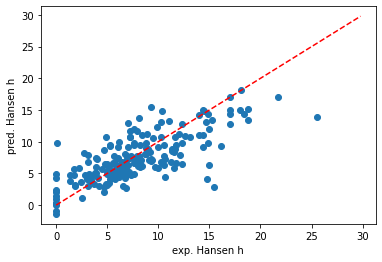

Fold:2, Train set: 986, Test set:197
2.333410826794387
3.2073285080346716
0.44200604869857063


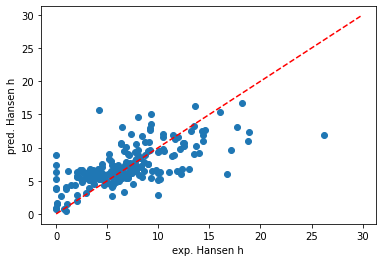

Fold:3, Train set: 986, Test set:197
2.1516831042046474
2.8155993259974927
0.5016219581057135


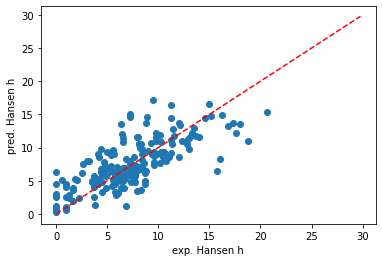

Fold:4, Train set: 986, Test set:197
2.145445992650114
2.9945836721537207
0.4909581838806554


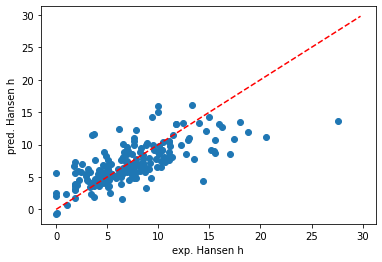

Fold:5, Train set: 986, Test set:197
2.3354480721926327
3.2520364225443195
0.475377049451557


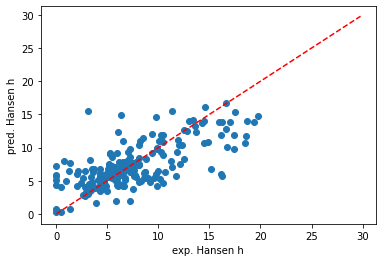

Fold:6, Train set: 986, Test set:197
2.233337896532819
2.8928305278907342
0.5441216649967247


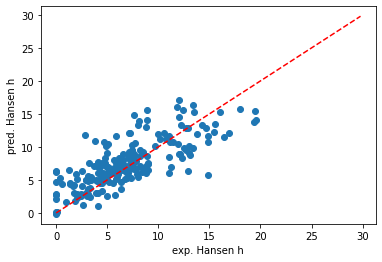

In [4]:
# split the data into 6 folds.  
# use'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=6, shuffle=True, random_state=42)

cnt = 1

# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(np_fps, hansen_p):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    fps_train, fps_test = np_fps[train_index], np_fps[test_index]
    hansen_train, hansen_test = hansen_p[train_index], hansen_p[test_index]
    index_train, index_test = mol_number[train_index], mol_number[test_index]
    smiles_train, smiles_test = mol_smiles[train_index], mol_smiles[test_index]
    
    # training model
    model = XGBRegressor().fit(fps_train, hansen_train)
    hansen_pred = model.predict(fps_test)
    
    print(mean_absolute_error (hansen_test, hansen_pred))
    print(math.sqrt(mean_squared_error(hansen_test, hansen_pred)))
    print(r2_score (hansen_test, hansen_pred))

    pd_hansen_pred = pd.DataFrame(hansen_pred, columns=["pred"])
    xg_output = pd.concat((index_test.reset_index(), smiles_test.reset_index(), hansen_test.reset_index(), pd_hansen_pred), ignore_index=True, axis=1)
    xg_output.to_csv(f'fps_xgboost_hansen_p_fold_{cnt}.csv')

    ln = np.arange(0, 30, 0.2)
    plt.plot(ln, ln,'r--')
    plt.scatter(hansen_test, hansen_pred)
    plt.plot(color='green')

    plt.xlabel('exp. Hansen h')
    plt.ylabel('pred. Hansen h')
    plt.show()
    
    cnt += 1
    